In [1]:
import scanpy as sc
import infercnvpy as cnv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import anndata as ad
from scipy.sparse import issparse
import matplotlib.colors as mcolors

In [2]:
def infercnv_heatmap(expression_df, obs, group_by, show_var_group = True, figsize = (16, 10), xlabel='', ylabel='', center=1):
    """
    
    """
    expression_df = expression_df[~expression_df.index.str.startswith('MT-')]
    tmp_adata = ad.AnnData(X=expression_df.values.T.astype(np.float32), obs=obs.loc[expression_df.columns])
    
    gtf = pd.read_csv('/home/dchafamo/final/results/infercnv/hg38_gencode_v27.csv', header=None)
    gtf.columns = [0,"gene", "chromosome", "start", "end"]
    gtf.index = gtf.gene
    gtf = gtf[["chromosome", "start", "end"]]
    gtf = gtf.loc[expression_df.index]
    
    chr_pos_dict = {c : np.where(gtf.chromosome.values == c)[0][0] for c in gtf.chromosome.unique()}
    chr_pos_dict = dict(sorted(chr_pos_dict.items(), key=lambda x: x[1]))
    chr_pos = list(chr_pos_dict.values())
    var_group_positions = list(zip(chr_pos, chr_pos[1:] + [tmp_adata.shape[1]]))
    
    norm = mcolors.TwoSlopeNorm(center, vmin=np.nanmin(tmp_adata.X), vmax=np.nanmax(tmp_adata.X))

    return_ax_dic = sc.pl.heatmap(
        tmp_adata,
        var_names=tmp_adata.var.index.values,
        groupby=group_by,
        cmap='bwr',
        show_gene_labels=False,
        var_group_positions=var_group_positions if show_var_group else None,
        var_group_labels=list(chr_pos_dict.keys()),
        norm=norm,
        show=False,
        figsize = figsize
    )
    return_ax_dic["heatmap_ax"].vlines(chr_pos[1:], lw=0.6, ymin=0, ymax=tmp_adata.shape[0], colors='k')
    return_ax_dic['heatmap_ax'].set_xlabel(xlabel)
    return_ax_dic['groupby_ax'].set_ylabel(ylabel) 
    return return_ax_dic

***
        Smoothed Expression Plots
***

In [ ]:
adata = sc.read_h5ad("/home/dchafamo/final/data/combined_dataset_final_v2.h5ad")
dmap = {v:f'Donor {k}' for k,v in enumerate(adata.obs.donor.unique())}
adata.obs['donor_id'] = adata.obs.donor.map(dmap)

In [13]:
group_by = 'donor_id'
obs = pd.DataFrame(adata.obs.loc[:,group_by])

In [4]:
obs_df = pd.read_csv('/home/dchafamo/final/results/infercnv/infercnv_2.observations.txt', sep=' ')
ref_df = pd.read_csv('/home/dchafamo/final/results/infercnv/infercnv_2.references.txt', sep=' ')
idx, col = list(adata.obs.index), list(ref_df.columns)
ref_df = ref_df.loc[:,np.in1d(col, idx)]

In [14]:
ebpos_df = obs_df.loc[:,adata.obs.loc[obs_df.columns].ebv_status == 'positive']
ebneg_df = obs_df.loc[:,adata.obs.loc[obs_df.columns].ebv_status == 'negative']

In [15]:
ebpos_df = ebpos_df.loc[:,obs.loc[ebpos_df.columns].groupby('donor_id', as_index=False, group_keys=False)\
                        .apply(lambda x: x.sample(min(500, len(x)))).index]
ebneg_df = ebneg_df.loc[:,obs.loc[ebneg_df.columns].groupby('donor_id', as_index=False, group_keys=False).\
                        apply(lambda x: x.sample(min(250, len(x)))).index]

... storing 'donor_id' as categorical
/home/dchafamo/anaconda3/envs/pyro/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()
... storing 'donor_id' as categorical
/home/dchafamo/anaconda3/envs/pyro/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()
... storing 'donor_id' as categorical
/home/dchafamo/anaconda3/envs/pyro/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


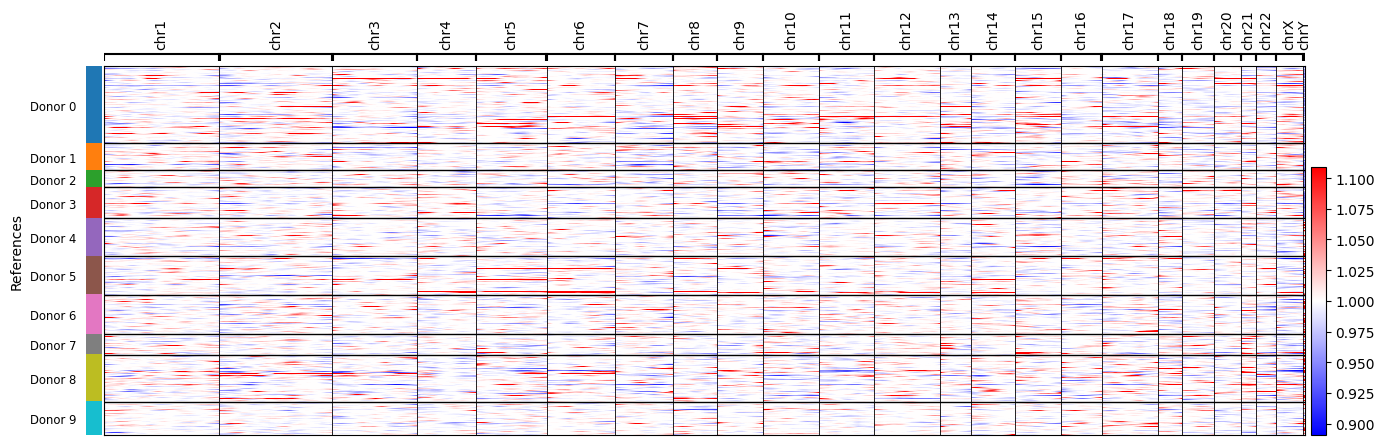

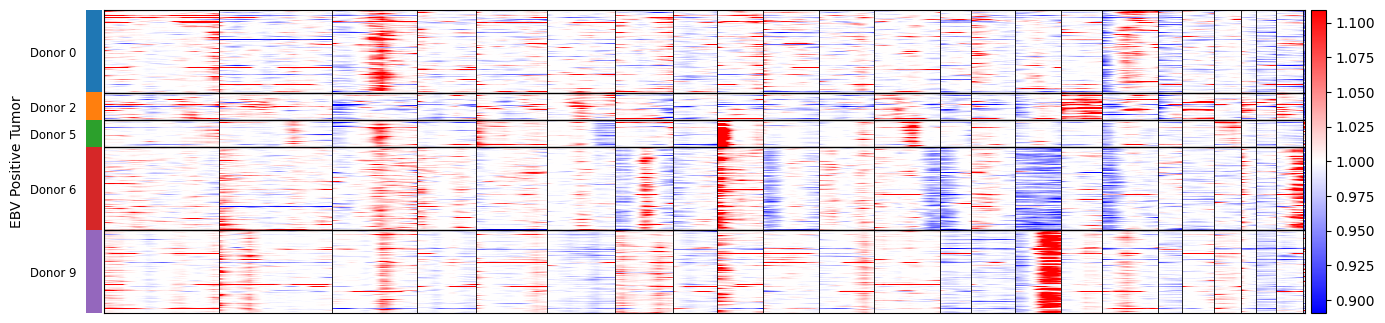

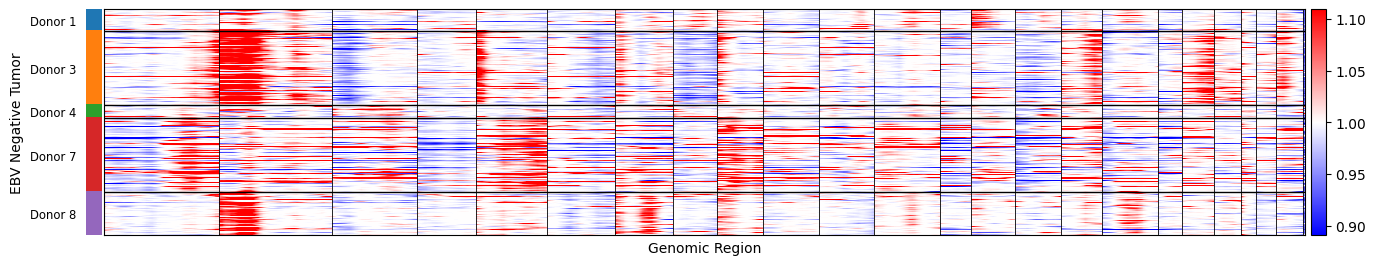

In [47]:
return_ax_dic = infercnv_heatmap(ref_df, obs, group_by, figsize = (16, 5), ylabel='References')
return_ax_dic = infercnv_heatmap(ebpos_df, obs, group_by, figsize = (16, 4), show_var_group = False, ylabel='EBV Positive Tumor')
return_ax_dic = infercnv_heatmap(ebneg_df, obs, group_by, figsize = (16, 3), show_var_group = False, ylabel='EBV Negative Tumor', 
                                 xlabel='Genomic Region')

***
***
        Infer CNV HMM results  
***
***

In [8]:
hmm_cnv = pd.read_csv("/home/dchafamo/final/results/infercnv/infercnv_hmm.csv", index_col=0)

In [9]:
hmm_cnv = hmm_cnv - 3

... storing 'donor_id' as categorical
/home/dchafamo/anaconda3/envs/pyro/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()
... storing 'donor_id' as categorical
/home/dchafamo/anaconda3/envs/pyro/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


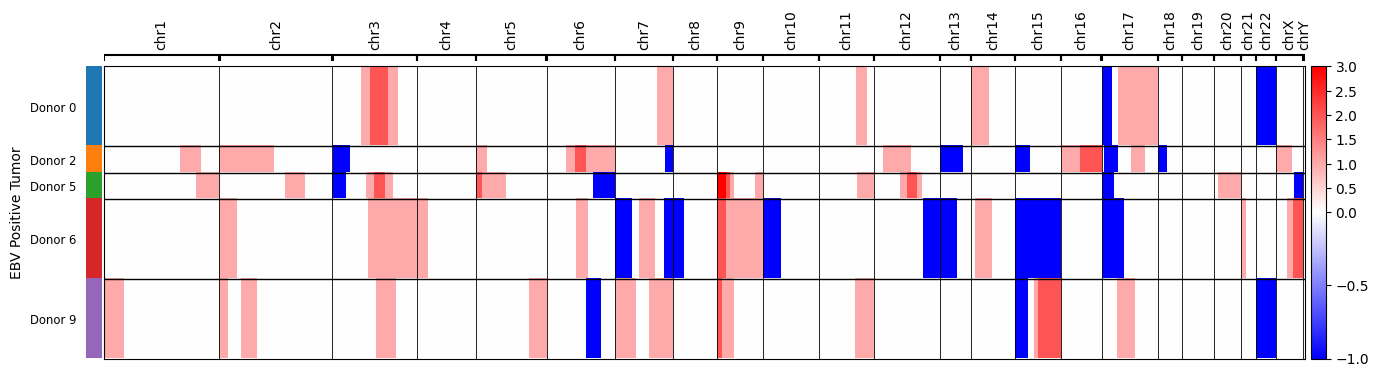

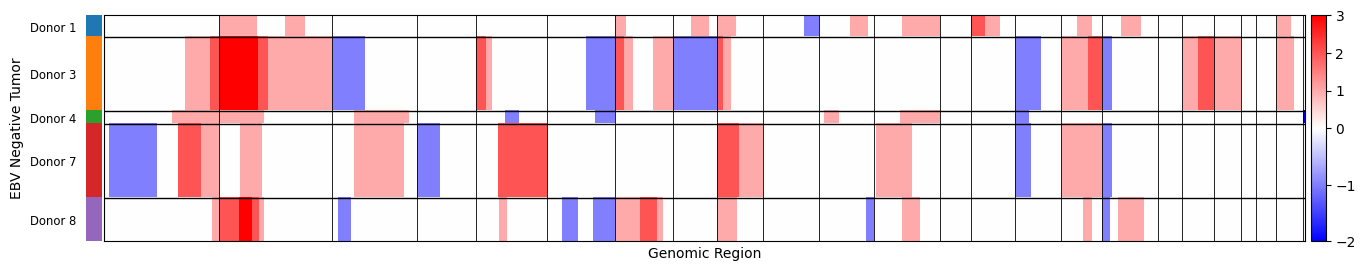

In [16]:
group_by = 'donor_id'
obs = pd.DataFrame(adata.obs.loc[:,group_by])

return_ax_dic = infercnv_heatmap(hmm_cnv.loc[:,ebpos_df.columns], obs, group_by, figsize = (16, 4), show_var_group = True, 
                                 ylabel='EBV Positive Tumor', center=0)
return_ax_dic = infercnv_heatmap(hmm_cnv.loc[:,ebneg_df.columns], obs, group_by, figsize = (16, 3), show_var_group = False, 
                                 ylabel='EBV Negative Tumor', xlabel='Genomic Region', center=0)